## CNN using frames and RESNET and all 5 emotes

AI/ CNN HW helped us generate this code - we used similar code for each frame based CNN


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DS340/frames.zip -d /content/


Archive:  /content/drive/MyDrive/DS340/frames.zip
   creating: /content/frames/
  inflating: /content/__MACOSX/._frames  
  inflating: /content/frames/.DS_Store  
  inflating: /content/__MACOSX/frames/._.DS_Store  
   creating: /content/frames/test/
  inflating: /content/__MACOSX/frames/._test  
   creating: /content/frames/original_frames/
  inflating: /content/__MACOSX/frames/._original_frames  
   creating: /content/frames/train/
  inflating: /content/__MACOSX/frames/._train  
   creating: /content/frames/validation/
  inflating: /content/__MACOSX/frames/._validation  
   creating: /content/frames/test/TongueOut/
  inflating: /content/__MACOSX/frames/test/._TongueOut  
   creating: /content/frames/test/HandsUp/
  inflating: /content/__MACOSX/frames/test/._HandsUp  
   creating: /content/frames/test/Cry/
  inflating: /content/__MACOSX/frames/test/._Cry  
   creating: /content/frames/test/Still/
  inflating: /content/__MACOSX/frames/test/._Still  
   creating: /content/frames/test/Yaw

In [4]:
!ls /content/frames/

original_frames  test  train  validation


In [5]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

print("PyTorch version:", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


PyTorch version: 2.9.0+cu126
Using device: cuda


In [6]:
from pathlib import Path

DATA_DIR = Path("/content/frames")

print("Root frames folder:", DATA_DIR)
print("Subfolders:", list(p.name for p in DATA_DIR.iterdir()))
print("Train classes:", os.listdir(DATA_DIR / "train"))
print("Val classes:", os.listdir(DATA_DIR / "validation"))
print("Test classes:", os.listdir(DATA_DIR / "test"))


Root frames folder: /content/frames
Subfolders: ['validation', 'train', 'original_frames', 'test', '.DS_Store']
Train classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']
Val classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']
Test classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']


In [18]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 5

## Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "validation"
test_dir  = DATA_DIR / "test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Class to index mapping:", train_dataset.class_to_idx)
idx_to_class = {v:k for k,v in train_dataset.class_to_idx.items()}
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


Class to index mapping: {'Cry': 0, 'HandsUp': 1, 'Still': 2, 'TongueOut': 3, 'Yawn': 4}
Train size: 596
Val size: 124
Test size: 144


In [8]:
from torchvision import models

# Load ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model ready.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


Model ready.


In [10]:
#one epoch functions
def train_one_epoch(epoch, model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    print(f"Epoch {epoch}: TRAIN   Loss={epoch_loss:.4f}  Acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device, split_name="VAL"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

    loss = running_loss / total
    acc = running_corrects / total
    print(f"{split_name}: Loss={loss:.4f}  Acc={acc:.4f}")
    return loss, acc


In [9]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [11]:
## Run with epochs of 15 and saves the best
NUM_EPOCHS = 15
best_val_acc = 0.0
best_model_path = "/content/best_resnet18_emotes.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE, "VAL")

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


    # Save best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model (val_acc={best_val_acc:.4f})")

print("Training finished. Best VAL accuracy:", best_val_acc)


Epoch 1: TRAIN   Loss=0.7537  Acc=0.7500
VAL: Loss=0.3211  Acc=0.8871
Saved new best model (val_acc=0.8871)
Epoch 2: TRAIN   Loss=0.1869  Acc=0.9564
VAL: Loss=0.2897  Acc=0.9032
Saved new best model (val_acc=0.9032)
Epoch 3: TRAIN   Loss=0.1064  Acc=0.9681
VAL: Loss=0.1733  Acc=0.9758
Saved new best model (val_acc=0.9758)
Epoch 4: TRAIN   Loss=0.0584  Acc=0.9899
VAL: Loss=0.1392  Acc=0.9435
Epoch 5: TRAIN   Loss=0.0564  Acc=0.9866
VAL: Loss=0.0657  Acc=0.9839
Saved new best model (val_acc=0.9839)
Epoch 6: TRAIN   Loss=0.0457  Acc=0.9916
VAL: Loss=0.1886  Acc=0.9435
Epoch 7: TRAIN   Loss=0.0414  Acc=0.9866
VAL: Loss=0.0497  Acc=0.9758
Epoch 8: TRAIN   Loss=0.0419  Acc=0.9916
VAL: Loss=0.1420  Acc=0.9274
Epoch 9: TRAIN   Loss=0.0395  Acc=0.9916
VAL: Loss=0.1781  Acc=0.9194
Epoch 10: TRAIN   Loss=0.0441  Acc=0.9849
VAL: Loss=0.0988  Acc=0.9516
Epoch 11: TRAIN   Loss=0.0339  Acc=0.9933
VAL: Loss=0.0707  Acc=0.9839
Epoch 12: TRAIN   Loss=0.0403  Acc=0.9866
VAL: Loss=0.0651  Acc=0.9839
Epoch

In [12]:
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    print("Loaded best model from disk.")

# Final test evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE, split_name="TEST")
print("Final TEST accuracy:", test_acc)


Loaded best model from disk.
TEST: Loss=0.1803  Acc=0.9236
Final TEST accuracy: 0.9236111111111112


In [22]:
drive_save_path = "/content/drive/MyDrive/DS340/best_resnet18_emotes.pth"
!cp /content/best_resnet18_emotes.pth "$drive_save_path"
print("Saved model to:", drive_save_path)


Saved model to: /content/drive/MyDrive/DS340/best_resnet18_emotes.pth


## Graphs

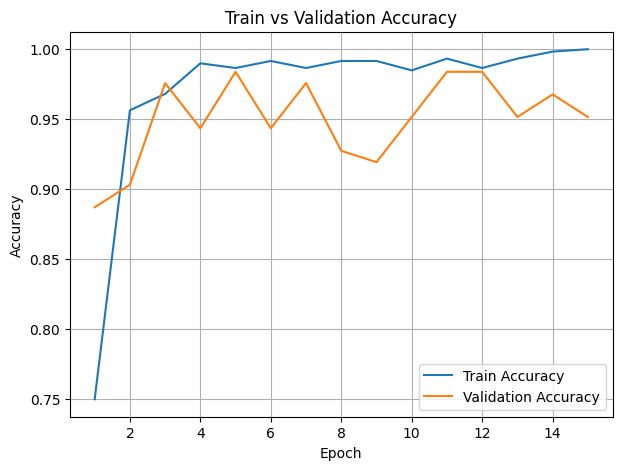

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import numpy as np
import torch.nn.functional as F

all_labels = []
all_preds  = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("Labels shape:", all_labels.shape)
print("Preds shape:", all_preds.shape)

Labels shape: (144,)
Preds shape: (144,)


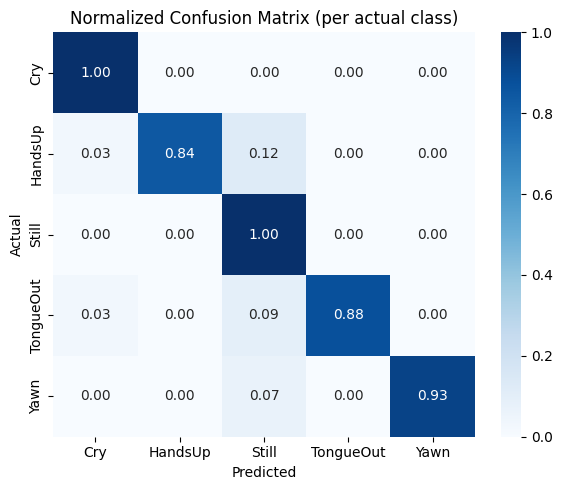

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


labels_list = list(range(NUM_CLASSES))

cm = confusion_matrix(all_labels, all_preds, labels=labels_list)

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

class_names = [idx_to_class[i] for i in labels_list]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (per actual class)")
plt.tight_layout()
plt.show()